<a href="https://colab.research.google.com/github/tanvir-152/Thesis_Codes/blob/main/weighted_FuNet_M_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   For Indian Pines
*   Weighted Multiplicative Fusion Model

  OA: 0.8000

  AA: 0.8821
  
  K: 0.7721

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
!pip install -U gast==0.2.2
!pip install tensorflow==1.14
!pip install tensorflow-determinism

  Preparing metadata (setup.py) ... done
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7538 sha256=99929cbda85dcff16ade45bd12308030883bb30d2cdd2d9e014623340cae7386
  Stored in directory: /root/.cache/pip/wheels/18/b1/c8/a85a897027fc6670d130b41059615b3962955f4a267c513673
Successfully built gast
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.20.1 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
ERROR: Could not find a version that satisfies the requirement tensorflow==1.14 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10

In [ ]:
def confusion_mat(x_out, y_in):
  x_cls = tf.transpose(x_out)
  y_cls = tf.transpose(y_in)
  x_cls = tf.argmax(x_out, 1)
  # x_cls = tf.nn.embedding_lookup(np.identity(16), x_cls_)
  # x_cls = convert_to_one_hot(np.array(x_cls)-1, 16)
  # TrLabel = TrLabel.T
  y_cls = tf.argmax(y_in, 1)
  confusion = v1.confusion_matrix(y_cls, x_cls, 16)
  return x_cls, y_cls, confusion

In [ ]:
"""
@author: danfeng
"""
#import library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as scio
import scipy.io as sio
from tf_utils import random_mini_batches_GCN1
from tensorflow.python.framework import ops
#from tfdeterminism import patch
#patch()
import tensorflow.compat.v1 as v1
#tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

In [ ]:
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

In [ ]:
def create_placeholders(n_x, n_x1, n_y):

    isTraining = v1.placeholder_with_default(True, shape=())
    x_in = v1.placeholder(tf.float32,  [None, n_x], name = "x_in")
    x_in1 = v1.placeholder(tf.float32,  [None, n_x1], name = "x_in1")
    y_in = v1.placeholder(tf.float32, [None, n_y], name = "y_in")
    lap_train = v1.placeholder(tf.float32, [None, None], name = "lap_train")

    return x_in, x_in1, y_in, lap_train, isTraining

In [ ]:
def initialize_parameters():

    v1.set_random_seed(1)

    x_w1 = v1.get_variable("x_w1", [200,128], initializer = tf.keras.initializers.GlorotUniform(seed = 1))
    x_b1 = v1.get_variable("x_b1", [128], initializer = v1.zeros_initializer())

    x_jw1 = v1.get_variable("x_jw1", [128,128], initializer = tf.keras.initializers.GlorotUniform(seed = 1))
    x_jb1 = v1.get_variable("x_jb1", [128], initializer = v1.zeros_initializer())

    x_jw2 = v1.get_variable("x_jw2", [128,16], initializer = tf.keras.initializers.GlorotUniform(seed = 1))
    x_jb2 = v1.get_variable("x_jb2", [16], initializer = v1.zeros_initializer())

    x_conv_w1 = v1.get_variable("x_conv_w1", [3,3,200,32], initializer = tf.keras.initializers.GlorotUniform(seed = 1))
    x_conv_b1 = v1.get_variable("x_conv_b1", [32], initializer = v1.zeros_initializer())

    x_conv_w2 = v1.get_variable("x_conv_w2", [3,3,32,64], initializer = tf.keras.initializers.GlorotUniform(seed = 1))
    x_conv_b2 = v1.get_variable("x_conv_b2", [64], initializer = v1.zeros_initializer())

    x_conv_w3 = v1.get_variable("x_conv_w3", [1,1,64,128], initializer = tf.keras.initializers.GlorotUniform(seed = 1))
    x_conv_b3 = v1.get_variable("x_conv_b3", [128], initializer = v1.zeros_initializer())

    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_jw1": x_jw1,
                  "x_jb1": x_jb1,
                  "x_jw2": x_jw2,
                  "x_jb2": x_jb2,
                  "x_conv_w1": x_conv_w1,
                  "x_conv_b1": x_conv_b1,
                  "x_conv_w2": x_conv_w2,
                  "x_conv_b2": x_conv_b2,
                  "x_conv_w3": x_conv_w3,
                  "x_conv_b3": x_conv_b3}

    return parameters

In [ ]:
def GCN_layer(x_in, L_, weights):

    x_mid = tf.matmul(x_in, weights)
    x_out = tf.matmul(L_, x_mid)

    return x_out

In [ ]:
def mynetwork(x, x1, parameters, Lap, isTraining, momentums = 0.9):

    x1 = tf.reshape(x1, [-1, 7, 7, 200], name = "x1")

    with tf.name_scope("x_layer_1"):

         x_z1_bn = v1.layers.batch_normalization(x, momentum = momentums, training = isTraining)
         x_z1 = GCN_layer(x_z1_bn, Lap, parameters['x_w1']) + parameters['x_b1']
         x_z1_bn = v1.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
         x_a1 = tf.nn.relu(x_z1_bn)

         x_conv_z1 = v1.nn.conv2d(x1, parameters['x_conv_w1'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b1']
         x_conv_z1_bn = v1.layers.batch_normalization(x_conv_z1, momentum = momentums, training = isTraining)
         x_conv_z1_po = v1.layers.max_pooling2d(x_conv_z1_bn, 2, 2, padding='SAME')
         x_conv_a1 = tf.nn.relu(x_conv_z1_po)

    with tf.name_scope("x_layer_2"):

         x_conv_z2 = v1.nn.conv2d(x_conv_a1, parameters['x_conv_w2'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b2']
         x_conv_z2_bn = v1.layers.batch_normalization(x_conv_z2, momentum = momentums, training = isTraining)
         x_conv_z2_po = v1.layers.max_pooling2d(x_conv_z2_bn, 2, 2, padding='SAME')
         x_conv_a2 = tf.nn.relu(x_conv_z2_po)

    with tf.name_scope("x_layer_3"):

         x_conv_z3 = v1.nn.conv2d(x_conv_a2, parameters['x_conv_w3'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b3']
         x_conv_z3_bn = v1.layers.batch_normalization(x_conv_z3, momentum = momentums, training = isTraining)
         x_conv_z3_po = v1.layers.max_pooling2d(x_conv_z3_bn, 2, 2, padding='SAME')
         x_conv_a3 = tf.nn.relu(x_conv_z3_po)

         x_conv_a3_shape = x_conv_a3.get_shape().as_list()
         x_conv_z3_2d = tf.reshape(x_conv_a3, [-1, x_conv_a3_shape[1] * x_conv_a3_shape[2] * x_conv_a3_shape[3]])


         #joint_encoder_layer1 = (x_a1 * x_conv_z3_2d)
         #joint_encoder_layer2 = (x_a1 + x_conv_z3_2d)
         #joint_encoder_layer = joint_encoder_layer1 + joint_encoder_layer2

         # Assuming the shape of joint_encoder_layer1 and joint_encoder_layer2 is the same
         input_shape = x_a1.get_shape().as_list()
         attention_weights = tf.Variable(tf.random.normal(shape=(input_shape[1],), stddev=0.1), trainable=True)
        # Calculate attention scores for each feature
         attention_scores1 = tf.nn.softmax(attention_weights)
         attention_scores2 = 1 - attention_scores1  # Using complement weights for the second feature
        # Apply attention weights to the features
         weighted_joint_encoder_layer1 = x_a1 * attention_scores1
         weighted_joint_encoder_layer2 = x_conv_z3_2d * attention_scores2
        # Combine the features using element-wise addition
         joint_encoder_layer = weighted_joint_encoder_layer1 * weighted_joint_encoder_layer2



    # Convert the predictions to class labels (indices of the maximum probability)
   # x_a1_class_labels = tf.argmax(x_a1_predictions, axis=1)
   # x_conv_z3_2d_class_labels = tf.argmax(x_conv_z3_2d_predictions, axis=1)

    # Perform voting to get the final predictions
    #final_predictions = tf.stack([x_a1_class_labels, x_conv_z3_2d_class_labels])
    #final_predictions = tf.math.mode(final_predictions, axis=0).values


    with tf.name_scope("x_joint_layer_1"):

         x_zj1 = tf.matmul(joint_encoder_layer, parameters['x_jw1']) + parameters['x_jb1']
         x_zj1_bn = v1.layers.batch_normalization(x_zj1, momentum = momentums, training = isTraining)
         x_aj1 = tf.nn.relu(x_zj1_bn)

    with tf.name_scope("x_layer_4"):
         x_zj2 = tf.matmul(x_aj1, parameters['x_jw2']) + parameters['x_jb2']

    l2_loss =  tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_jw1']) + tf.nn.l2_loss(parameters['x_jw2'])\
               + tf.nn.l2_loss(parameters['x_conv_w1']) + tf.nn.l2_loss(parameters['x_conv_w2'])  + tf.nn.l2_loss(parameters['x_conv_w3'])

    return x_zj2, l2_loss

In [ ]:
def mynetwork_optimaization(y_est, y_re, l2_loss, reg, learning_rate, global_step):

    y_re = tf.squeeze(y_re, name = 'y_re')

    with tf.name_scope("cost"):
         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_est, labels = y_re)) +  reg * l2_loss

    with tf.name_scope("optimization"):
         update_ops = v1.get_collection(v1.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost,  global_step=global_step)
         optimizer = v1.group([optimizer, update_ops])

    return cost, optimizer

In [ ]:
def train_mynetwork(x_train, x_test, train_x, test_x, y_train, y_test, L_train, L_test, learning_rate_base = 0.001, beta_reg = 0.001, num_epochs = 200, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()
    v1.set_random_seed(1)
    seed = 1
    (m, n_x) = x_train.shape
    (m, n_y) = y_train.shape
    (m, n_x1) = train_x.shape

    costs = []
    costs_dev = []
    train_acc = []
    val_acc = []

    x_in, x_in1, y_in, lap_train, isTraining = create_placeholders(n_x, n_x1, n_y)

    parameters = initialize_parameters()

    with tf.name_scope("network"):
         x_out, l2_loss = mynetwork(x_in, x_in1, parameters, lap_train, isTraining)

    global_step = tf.Variable(0, trainable=False)
    learning_rate = v1.train.exponential_decay(learning_rate_base, global_step, 50 * m/minibatch_size, 0.5, staircase = True)

    with tf.name_scope("optimization"):
         cost, optimizer = mynetwork_optimaization(x_out, y_in, l2_loss, beta_reg, learning_rate, global_step)

    with tf.name_scope("metrics"):
         joint_layerT = tf.transpose(x_out)
         yT = tf.transpose(y_in)
         correct_prediction = tf.equal(tf.argmax(joint_layerT), tf.argmax(yT))
         accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    with tf.name_scope("con"):
         x_cls, y_cls, confusion = confusion_mat(x_out,y_in)

    init = v1.global_variables_initializer()

    with v1.Session() as sess:

        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs + 1):
            epoch_cost = 0.                       # Defines a cost related to an epoch
            epoch_acc = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches_GCN1(x_train, train_x, y_train, L_train, minibatch_size, seed)
            for minibatch in minibatches:

                # Select a minibatch
                (batch_x, batch_x1, batch_y, batch_l) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost, minibatch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x_in: batch_x, x_in1: batch_x1, y_in: batch_y, lap_train: batch_l, isTraining: True})

                epoch_cost += minibatch_cost / (num_minibatches+ 1)
                epoch_acc += minibatch_acc / (num_minibatches + 1)


            if print_cost == True and (epoch) % 50 == 0:
                features, epoch_cost_dev, epoch_acc_dev = sess.run([x_out, cost, accuracy], feed_dict={x_in: x_test, x_in1: test_x, y_in: y_test, lap_train: L_test, isTraining: False})
                print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost, epoch_cost_dev, epoch_acc, epoch_acc_dev))

            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                train_acc.append(epoch_acc)
                costs_dev.append(epoch_cost_dev)
                val_acc.append(epoch_acc_dev)

            if print_cost == True and epoch == 200:
                # con_mat =
                x, y, confusion = sess.run([x_cls, y_cls, confusion], feed_dict={x_in: x_test, x_in1: test_x, y_in: y_test, lap_train: L_test, isTraining: False})


        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(costs_dev))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        # plot the accuracy
        plt.plot(np.squeeze(train_acc))
        plt.plot(np.squeeze(val_acc))
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        return parameters, val_acc, features, x, y, confusion


In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [ ]:
X_train = scio.loadmat('HSI_CNN/X_train.mat')
X_test = scio.loadmat('HSI_CNN/X_test.mat')
Train_X = scio.loadmat('HSI_GCN/Train_X.mat')
TrLabel = scio.loadmat('HSI_GCN/TrLabel.mat')
Test_X = scio.loadmat('HSI_GCN/Test_X.mat')
TeLabel = scio.loadmat('HSI_GCN/TeLabel.mat')
Train_L = scio.loadmat('HSI_GCN/Train_L.mat')
Test_L = scio.loadmat('HSI_GCN/Test_L.mat')



X_train = X_train['X_train']
X_test = X_test['X_test']
Train_X = Train_X['Train_X']
Test_X = Test_X['Test_X']
TrLabel = TrLabel['TrLabel']
TeLabel = TeLabel['TeLabel']

Train_L = Train_L['Train_L']
Test_L = Test_L['Test_L']


TrLabel = convert_to_one_hot(TrLabel-1, 16)
TeLabel = convert_to_one_hot(TeLabel-1, 16)
TrLabel = TrLabel.T
TeLabel = TeLabel.T



<ipython-input-10-987b8f514093>:7: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_z1_bn = v1.layers.batch_normalization(x, momentum = momentums, training = isTraining)
Instructions for updating:
Colocations handled automatically by placer.
<ipython-input-10-987b8f514093>:9: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_z1_bn = v1.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
<ipython-input-10-987b8f514093>:13: UserWarning: `tf.layers

epoch 0: Train_loss: 2.541863, Val_loss: 2.897753, Train_acc: 0.328121, Val_acc: 0.307931
epoch 50: Train_loss: 0.252248, Val_loss: 2.815928, Train_acc: 0.992898, Val_acc: 0.588564
epoch 100: Train_loss: 0.174286, Val_loss: 1.141551, Train_acc: 0.997159, Val_acc: 0.765898
epoch 150: Train_loss: 0.132370, Val_loss: 1.059031, Train_acc: 1.000000, Val_acc: 0.799193
epoch 200: Train_loss: 0.111127, Val_loss: 0.994313, Train_acc: 1.000000, Val_acc: 0.800021


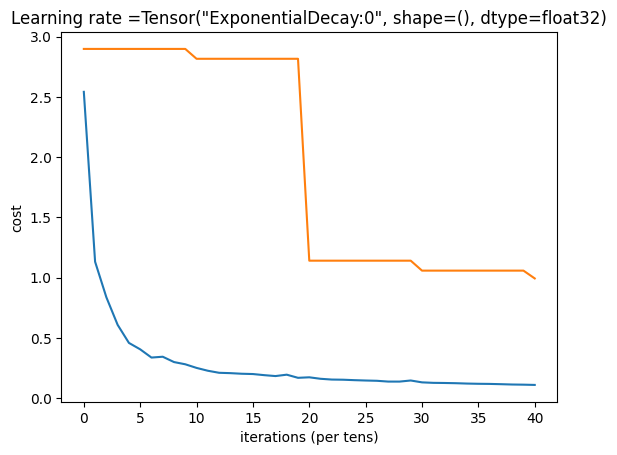

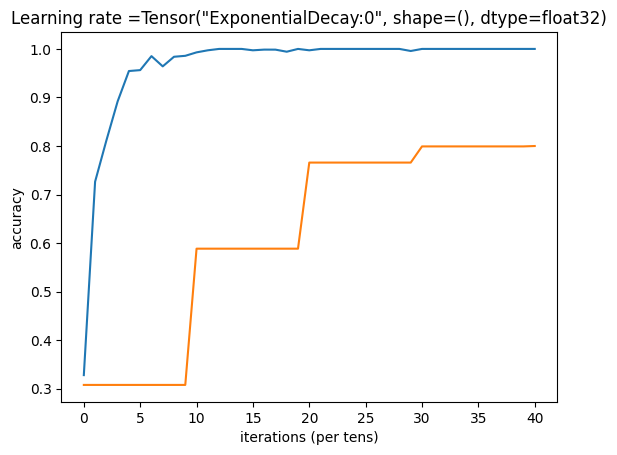

Parameters have been trained!


In [ ]:
parameters, val_acc, features, x, y, confusion = train_mynetwork(Train_X, Test_X, X_train, X_test, TrLabel, TeLabel, Train_L, Test_L)
sio.savemat('features.mat', {'features': features})

<Axes: >

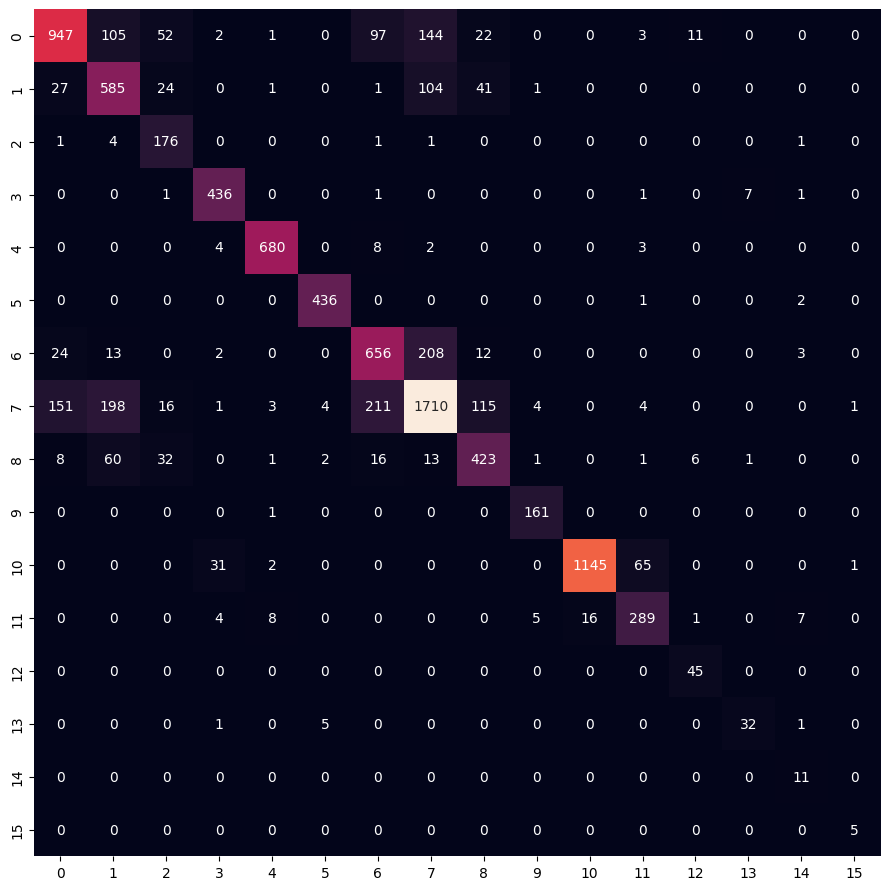

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (11,11))
sn.heatmap(confusion, square=True, annot=True, fmt='d', cbar=False)

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y, x)

0.7721478280327169

In [ ]:
from sklearn.metrics import classification_report
target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
print(classification_report(y, x, target_names=target_names, digits=4))

              precision    recall  f1-score   support

           1     0.8178    0.6842    0.7451      1384
           2     0.6062    0.7462    0.6690       784
           3     0.5847    0.9565    0.7258       184
           4     0.9064    0.9754    0.9397       447
           5     0.9756    0.9756    0.9756       697
           6     0.9754    0.9932    0.9842       439
           7     0.6620    0.7146    0.6873       918
           8     0.7837    0.7072    0.7435      2418
           9     0.6900    0.7500    0.7188       564
          10     0.9360    0.9938    0.9641       162
          11     0.9862    0.9204    0.9522      1244
          12     0.7875    0.8758    0.8293       330
          13     0.7143    1.0000    0.8333        45
          14     0.8000    0.8205    0.8101        39
          15     0.4231    1.0000    0.5946        11
          16     0.7143    1.0000    0.8333         5

    accuracy                         0.8000      9671
   macro avg     0.7727   

In [ ]:
from sklearn.metrics import classification_report
target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
c_p = (classification_report(y, x, target_names=target_names, digits=4, output_dict=True))
r = np.zeros(17)
for key in range(1,17):
  c = str(key)
  r[key] = round((c_p[c]['recall']),4)

print("Average accuracy:",round((sum(r)/16),4))

Average accuracy: 0.8821
